# MIDI music generation with Transformer

In this notebook we'll be presenting various approaches for training a Transformer model that generates music in the form of MIDI (Musical Instrument Digital Interface) files.

Notebook presented for the A.A. 2023/2024 Deep Learning project.

Group members:

- Valerio Di Zio - valerio.dizio@studio.unibo.it
- Francesco Magnani - francesco.magnani14@studio.unibo.it
- Luca Rubboli - mail@diluca.it

## Installation of libraries

In this notebook only 3 additional libraries are needed (plus the ones already installed on Colab runtimes):
- `pretty_midi` is a utility library to manage MIDI files
- `miditok` is library that provides several implementations of MIDI tokenization algorithms, useful for training AI models on tokens that represent MIDI data
- `transformers` is a popular library for building and training AI models

In [ ]:
%%capture
!pip install pretty_midi
!pip install miditok
!pip install transformers

## Dataset Download

We will use the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro) for training the first Transformer model.

This dataset contains MIDI files taken from several piano performances.

In [ ]:
%%capture
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
!unzip "maestro-v3.0.0-midi.zip"
!rm "maestro-v3.0.0-midi.zip"

dataset_path = "maestro-v3.0.0"

## Libraries
Here we import all the necessary libraries for this notebook.

In [ ]:
import json
import numpy as np
import os
import random
import shutil
from pathlib import Path
from random import shuffle

import pretty_midi
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from miditok import REMI, TokenizerConfig
from miditok.data_augmentation import augment_dataset
from miditok.utils import split_files_for_training
from tqdm import tqdm

## File setup

Before processing the MIDI files, we first organize them by moving each file into a new folder named midis and renaming them sequentially using integer indices.

In [ ]:
# Paths to the files of the dataset
midi_paths = list(Path(dataset_path).resolve().glob("**/*.mid")) + list(Path(dataset_path).resolve().glob("**/*.midi"))

midis_dir = "midis"
os.makedirs(midis_dir, exist_ok=True)

for i, midi_path in enumerate(midi_paths):
  new_midi_path = os.path.join(midis_dir, f"{i}.midi")
  shutil.move(str(midi_path), new_midi_path)


midis = list(Path("midis").resolve().glob("**/*.mid")) + list(Path("midis").resolve().glob("**/*.midi"))

def sample():
  return str(random.choice(midis))

# Data analysis

## MIDI format

The **MIDI** (Musical Instrument Digital Interface) file format is a standard for representing musical performance data. It doesn’t store actual audio but rather instructions for playback, such as notes, timing, and instrument settings.

The key components contained inside MIDI files are:
1.	**Tracks**: MIDI files contain one or more tracks, each holding a sequence of events.
2.	**Events**:
  - *Note On/Off*: Indicates when a note starts and stops, along with its pitch and velocity (volume).
	- *Control Changes*: Adjust settings like volume, pan, or effects.
	- *Program Changes*: Switches instruments (e.g. piano to guitar).
	- *Meta Events*: Provide additional information like tempo, time signature, and track names.
3.	**Channels**: MIDI supports up to 16 channels, each typically assigned to a different instrument.
4.	**Timing**: MIDI uses ticks (subdivisions of a beat) to precisely time events.

Many python libraries to handle MIDI files exist, here `pretty_midi` will be used as it appears sufficiently flexible and easy to use.

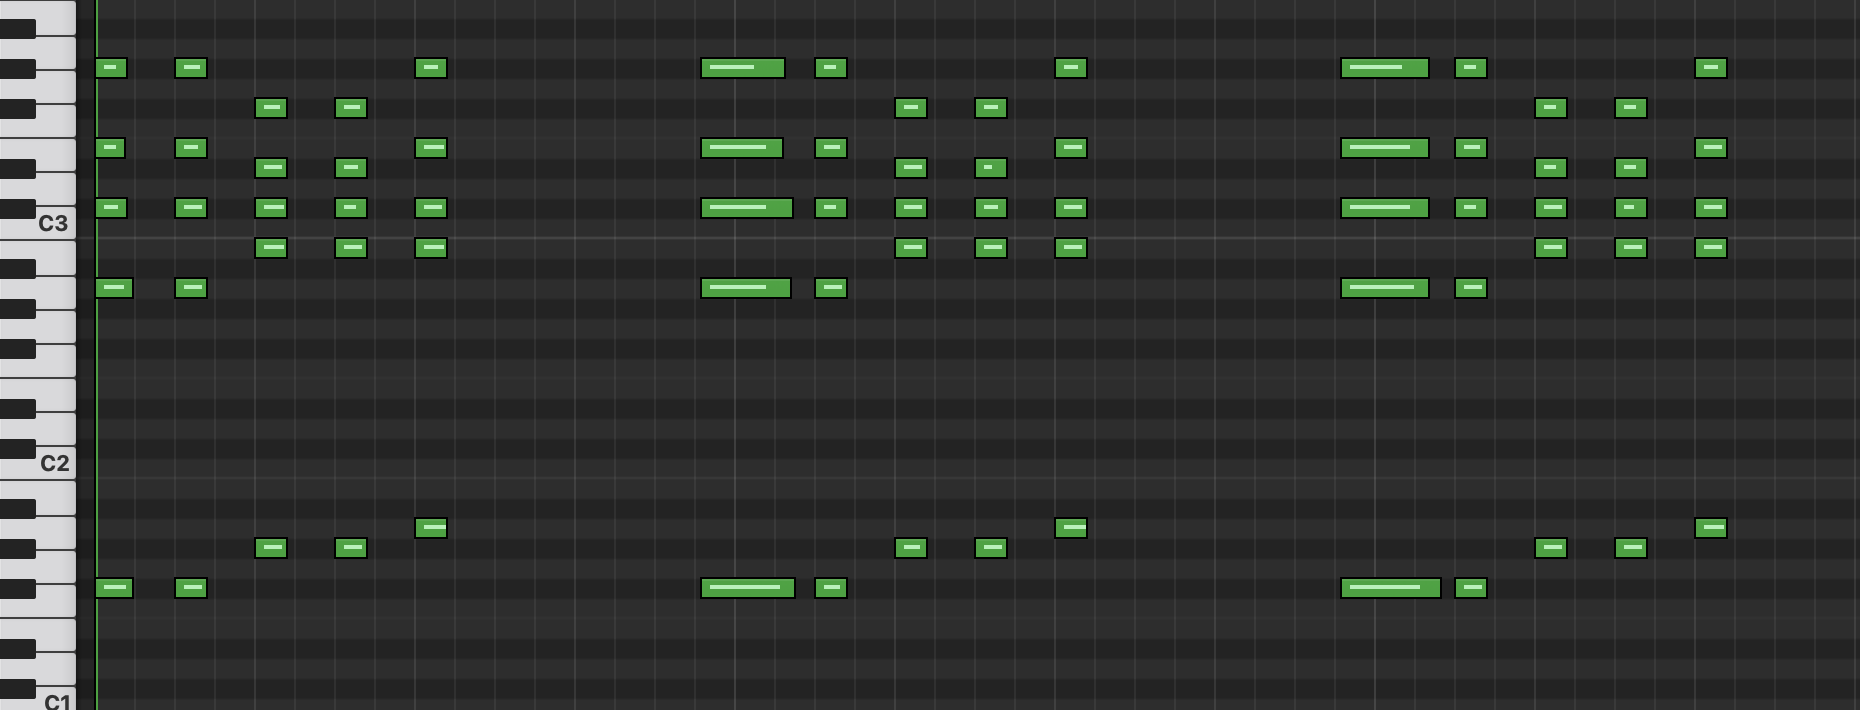

## Tokenization

We cannot directly use MIDI files as input for an AI model, so we must transform them into a numerical representation, similar to how text data is processed for models. To achieve this, we need a **tokenizer**.

A tokenizer is a tool that converts the raw MIDI data into a sequence of *tokens* that the AI model can understand.

In the context of MIDI tokenization, each token represents a specific musical element or event, such as a note, velocity, or duration. These tokens act as the “vocabulary” for the model, enabling it to learn and generate music.

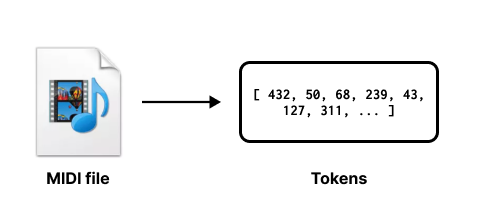

### First approach to tokenization
Tokenization is probably one of the most important steps in the process.

Our first approach to tokenization used an intermediate *string representation* for notes obtained in the following way:

"`<NOTE>`-`<DURATION>`", where `NOTE` represents the note in [letter notation](https://en.wikipedia.org/wiki/Letter_notation) followed by the octave of the note, and `DURATION` represents the duration in seconds.

*Example*: "C4-1.0, C4-1.0, G4-1.0, G4-1.0, A4-1.0, A4-1.0, G4-2.0, F4-1.0, F4-1.0, E4-1.0, E4-1.0, D4-1.0, D4-1.0, C4-2.0, G4-1.0, G4-1.0, F4-1.0, F4-1.0, E4-1.0, E4-1.0, D4-2.0, G4-1.0, G4-1.0, F4-1.0, F4-1.0, E4-1.0, E4-1.0, D4-2.0"

As can be easily deduced, this type of tokenization does not allow for a complete representation of MIDI files. For example, it cannot represent simultaneous or overlapping notes (polyphony) or other MIDI events such as tempo changes. However, it also has an advantage over other tokenization methods: its “1 token = 1 note” correspondence. This makes it much easier for the model to learn how to generate token sequences that produce valid notes, instead of “garbage” tokens that cannot be converted into valid MIDI.


**Since this method appears to perform worse than Miditok, it will not be used as the main tokenizer in this notebook.**

In [ ]:
STRING_TOKENIZATION = False
if STRING_TOKENIZATION:
  def find_midi_files(directory):
      """Recursively finds all MIDI files in the directory."""
      midi_files = []
      for root, _, files in os.walk(directory):
          for file in files:
              if file.endswith((".mid", ".midi")):
                  midi_files.append(os.path.join(root, file))
      return midi_files

  def midi_to_note_representation(file_path):
      """Converts a MIDI file into a note-duration representation."""
      try:
          midi_data = pretty_midi.PrettyMIDI(file_path)
          note_events = []

          for instrument in midi_data.instruments:
              for note in instrument.notes:
                  # Convert pitch to note name
                  note_name = pretty_midi.note_number_to_name(note.pitch)
                  duration = note.end - note.start
                  note_events.append(f"{note_name}-{duration:.1f}")

          return ", ".join(note_events)
      except Exception as e:
          print(f"Error in file conversion {file_path}: {e}")
          return None

  def create_dataset_from_midi(midi_files, output_file):
      """Creates a JSON dataset with the representation of notes from MIDI files."""
      dataset = {}

      for midi_file in tqdm(midi_files):
          note_representation = midi_to_note_representation(midi_file)
          if note_representation:
              dataset[midi_file] = note_representation

      with open(output_file, "w") as json_file:
          json.dump(dataset, json_file, indent=4)

      print(f"Dataset created and saved in {output_file}")

  output_dataset_file = "midi_dataset.json"

  string_midis = [str(midi) for midi in midis]
  create_dataset_from_midi(string_midis, output_dataset_file)

  dataset_file = "midi_dataset.json"

  with open(dataset_file, "r") as json_file:
      dataset = json.load(json_file)
      maestro_dataset = list(dataset.values())

  tokenizer = Tokenizer(filters="", lower=False, split=",")
  tokenizer.fit_on_texts(maestro_dataset)
  tokenized_melodies = tokenizer.texts_to_sequences(maestro_dataset)

### MidiTok

The MidiTok library provides predefined tokenization methods (e.g. **REMI**) to translate MIDI events into tokens and vice versa, ensuring a structured and efficient representation of musical data.

Compared to the previous tokenization method, MidiTok allows for a more comprehensive translation of MIDI events into tokens, with less information loss.

In [ ]:
# BEAT_RES defines the temporal resolution for tokenizing MIDI events,
# mapping beat intervals to the number of subdivisions per beat.
BEAT_RES = {(0, 1): 12, (1, 2): 4, (2, 4): 2, (4, 8): 1}

TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),  # ranges of possible pitches
    "beat_res": BEAT_RES,
    "num_velocities": 24,      # number of possible velocities for notes
    "special_tokens": ["PAD", "BOS", "EOS"], # special tokens
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "use_time_signatures": True,
    "use_programs": False,     # no multitrack
    "num_tempos": 32,          # number of possible tempos for notes
    "tempo_range": (50, 200),  # (min_tempo, max_tempo)
}

config = TokenizerConfig(**TOKENIZER_PARAMS)

# REMI is only one of the tokenization method available in MidiTok
# Here this one is used since it's been proven to work effectively
tokenizer = REMI(config)

### (Optional): train the tokenizer

One of the features that MidiTok offers is the **training of a tokenizer**.
Taken from MidiTok's documentation:

> Training a tokenizer consists in populating the vocabulary with new tokens representing successions of these basic tokens, that will be fetched from a training corpus. [...] For symbolic music, training the tokenizer allows to **increase both the model’s performances and efficiency**.

In order to do that, MidiTok uses algorithms like **Byte Pair Encoding (BPE)** to "pack" groups of tokens that appear frequently in the dataset into new tokens of the vocabulary.

The explanation for why this technique can improve the model’s performance is quite simple: the model’s “effort” in generating meaningful token sequences is reduced. Instead of learning to produce multiple “correct” tokens in sequence, it can directly produce a single token that corresponds to that sequence of MIDI events.

In [ ]:
# @title Manually train the tokenizer
TRAIN_TOKENIZER = False # @param { type: 'boolean' }

In [ ]:
if TRAIN_TOKENIZER:
  tokenizer.train(vocab_size=30000, files_paths=midis)
  processed = [Path(f"{s}") for s in midis]
  print(len(processed))

### Load a trained tokenizer

To avoid re-training a tokenizer from scratch, here we provide an already trained one.

In [ ]:
!gdown 1SDRkoWwyuSl4udoCHdcitjLLm9d0kfxS
tokenizer = REMI(params=Path("maestro_tokenizer.json"))
print(f"Vocab size: {len(tokenizer)}")

## Dataset preparation

In the following cells we prepare the dataset for training by splitting it into Train, Validation and Test sets. In addition, we exploit some methods made available by MidiTok to perform data augmentation.

### Download the clean data

If you want to skip all the data preparation, here we provide the data already cleaned and tokenized, in the form of numpy arrays.

In [ ]:
!gdown 1IQToXD9s8g4L-AlK-MY4qvGoLZ-p7bMw
!gdown 1DWjViUKpW07LfbGimlhhhGdK7oQaJpj-

all_ids_train = np.loadtxt("all_ids_maestro_train.txt").astype(np.int32)
all_ids_valid = np.loadtxt("all_ids_maestro_valid.txt").astype(np.int32)

In [ ]:
# @title ### (Optional): skip all the data preparation
SKIP_DATA_PREPARATION = True # @param { type: 'boolean' }

In [ ]:
if not SKIP_DATA_PREPARATION:

  total_num_files = len(processed)
  num_files_valid = round(total_num_files * 0.15)
  num_files_test = round(total_num_files * 0.15)
  shuffle(processed)
  midi_paths_valid = processed[:num_files_valid]
  midi_paths_test = processed[num_files_valid:num_files_valid + num_files_test]
  midi_paths_train = processed[num_files_valid + num_files_test:]

  # Chunk MIDIs and perform data augmentation on each subset independently

  for files_paths, subset_name in (
      (midi_paths_train, "train"),
      (midi_paths_valid, "valid"),
        (midi_paths_test, "test")
  ):
      # Split the MIDIs into chunks of sizes approximately about 1024 tokens
      subset_chunks_dir = Path(f"Maestro_{subset_name}")

      split_files_for_training(
          files_paths=files_paths,
          tokenizer=tokenizer,
          save_dir=subset_chunks_dir,
          max_seq_len=1024,
          num_overlap_bars=2,
      )

      # Perform data augmentation (generates new MIDI files with notes modified
      # by adding the related pitch, velocity and duration offsets)
      augment_dataset(
          subset_chunks_dir,
          pitch_offsets=[-12, 12],
          velocity_offsets=[-4, 4],
          duration_offsets=[-0.5, 0.5],
      )
  midi_paths_train = list(Path("Maestro_train").glob("**/*.mid")) + list(Path("Maestro_train").glob("**/*.midi"))
  midi_paths_valid = list(Path("Maestro_valid").glob("**/*.mid")) + list(Path("Maestro_valid").glob("**/*.midi"))
  midi_paths_test = list(Path("Maestro_test").glob("**/*.mid")) + list(Path("Maestro_test").glob("**/*.midi"))


### Tokenization

Here we tokenize the augmented dataset into JSON files containing the IDs of the tokens.

In [ ]:
if not SKIP_DATA_PREPARATION:
  def midi_valid(midi) -> bool:
      if any(ts.numerator != 4 for ts in midi.time_signature_changes):
          return False  # time signature different from 4/*, 4 beats per bar
      return True

  if os.path.exists("tokenized"):
    shutil.rmtree("tokenized")

  for dir in ("train", "valid", "test"):
      tokenizer.tokenize_dataset(
          Path(f"Maestro_{dir}").resolve(),
          Path(f"tokenized_{dir}").resolve(),
          midi_valid,
      )

### Read JSON files

Here we read the produced JSON files containing MidiTok tokenization's output.

In [ ]:
if not SKIP_DATA_PREPARATION:
  def read_json(path: str) -> dict:
    with open(path, "r") as f:
      return json.load(f)

  def read_json_files(json_file_paths):
      """Reads a list of JSON files and returns a list of objects.
      Args:
          json_file_paths: A list of file paths to JSON files.
      Returns:
          A list of objects, where each object represents the data from a JSON file.
          Returns an empty list if any error occurs during file processing.
      """
      objects = []

      for file_path in tqdm(json_file_paths):
          try:
              objects.append(read_json(file_path))
          except FileNotFoundError:
              print(f"Error: File not found - {file_path}")
              return []
          except json.JSONDecodeError:
              print(f"Error decoding JSON in file: {file_path}")
              return []
      return objects

  tokenized_train = list(Path("tokenized_train").resolve().glob("**/*.json"))
  data_objects_train = read_json_files(tokenized_train)

  tokenized_valid = list(Path("tokenized_valid").resolve().glob("**/*.json"))
  data_objects_valid = read_json_files(tokenized_valid)

  tokenized_test = list(Path("tokenized_test").resolve().glob("**/*.json"))
  data_objects_test = read_json_files(tokenized_test)


  if data_objects_train and data_objects_valid and data_objects_test:
      print(f"\nSuccessfully read {len(data_objects_train)} training JSON files.")
      print(f"Successfully read {len(data_objects_valid)} validation JSON files.")
      print(f"Successfully read {len(data_objects_test)} test JSON files.")
  else:
      print("Error reading JSON files.")

### Concatenate all IDs into a numpy array

Instead of working with padded songs (where each MIDI file, translated into tokens, is padded with a special padding token to reach a fixed length), we adopt a different approach. The token IDs of all piano pieces are concatenated into a single, large NumPy array.

While this method has clear drawbacks — such as reduced musical coherence when feeding the data into the model and a diminished sense of a song “as a whole” — it offers significantly greater flexibility in managing the data.

In [ ]:
if not SKIP_DATA_PREPARATION:
  encoded_train = [np.array(song["ids"][0]) for song in data_objects_train]
  encoded_valid = [np.array(song["ids"][0]) for song in data_objects_valid]
  encoded_test = [np.array(song["ids"][0]) for song in data_objects_test]

  all_ids_train = np.concatenate(encoded_train)
  all_ids_valid = np.concatenate(encoded_valid)
  all_ids_test = np.concatenate(encoded_test)

### Create Tensorflow Dataset

The numpy array is converted into a Tensorflow dataset...

In [ ]:
ids_dataset_train = tf.data.Dataset.from_tensor_slices(all_ids_train)
ids_dataset_valid = tf.data.Dataset.from_tensor_slices(all_ids_valid)

### Convert into sequences

...and then split into sequences of fixed size (i.e. `SEQ_LENGTH`).

The reason why `SEQ_LENGTH + 1` is used will be explained in the next cell.

In [ ]:
SEQ_LENGTH = 1024

sequences_train = ids_dataset_train.batch(SEQ_LENGTH+1, drop_remainder=True)
sequences_valid = ids_dataset_valid.batch(SEQ_LENGTH+1, drop_remainder=True)

### Preparing labels

In order to feed data into the model for training, we need to prepare the **labels**.

Since the model we are going to use works using **logits** and predicting the next token of the sequence, the *input sequence* - the X - is the sequence obtained by excluding the last token (i.e. `sequence[:-1]`) while the *target sequence* - the Y - is the same sequence shifted forward by 1 (i.e. `sequence[1:]`).

This is why, in order to maintain a sequence length of `SEQ_LENGTH`, we previously prepared sequences by adding that extra token.

In [ ]:
def split_input_target(sequence):
    input_seq = tf.cast(sequence[:-1], tf.int32)
    target_seq = tf.cast(sequence[1:], tf.int32)
    return input_seq, target_seq

train_ds = sequences_train.map(split_input_target)
valid_ds = sequences_valid.map(split_input_target)

### Create training batches

Similarly to how we created the sequences, we now create the final datasets creating the **batches**.

*Note:* Buffer size is used by Tensorflow when shuffling the dataset. Taken from Tensorflow:

> TF data is designed to work with possibly infinite sequences, so it doesn't attempt to shuffle the entire sequence in memory. Instead, it maintains a buffer in which it shuffles elements.

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 10000

train_ds = (
    train_ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))
valid_ds = (
    valid_ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

## Building Model

In [ ]:
from transformers import TFAutoModelForCausalLM, MistralConfig

# Define the model configuration
model_config = MistralConfig(
    vocab_size=len(tokenizer),
    hidden_size=512,
    intermediate_size=1024,
    num_hidden_layers=8,
    num_attention_heads=8,
    num_key_value_heads=4,
    sliding_window=256,
    max_position_embeddings=8192,
    pad_token_id=tokenizer['PAD_None'],
    bos_token_id=tokenizer['BOS_None'],
    eos_token_id=tokenizer['EOS_None'],
)

# Initialize the TensorFlow model
model = TFAutoModelForCausalLM.from_config(model_config)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,
              optimizer="adam",
              weighted_metrics=["sparse_categorical_accuracy"],
              jit_compile=True,
              )

## Train

In [ ]:
!gdown 1qoTIkmhmj0z4854FFofz02KLk5DnyqB1
!unzip NESGEN_Maestro15.zip

model.from_pretrained("nesgen-maestro0612")

### (Optional): Train model
Training of this model is made optional, free colab does not allow for this training.

In [ ]:
TRAIN = False
if TRAIN:
  EPOCHS = 15

  history = model.fit(
      train_ds,
      epochs=EPOCHS,
      validation_data=valid_ds,
  )

## Generation

### Select a seed from the test set

In [ ]:
def get_seed():
    for seed_ids, _ in valid_ds.take(1):
      seed = seed_ids
    return seed[0]

### Generate and dump MIDI


In [ ]:
dump_seed = False

seed = get_seed()
input_ids = tf.convert_to_tensor(seed)  # Assuming seed is a 1D tensor of token IDs
input_ids = tf.expand_dims(input_ids, 0)  # Add an extra dimension to represent batch size

if dump_seed:
    midi = tokenizer.decode([seed])
    midi.dump_midi("seed.mid")

# Generate continuation
outputs = model.generate(
    input_ids=input_ids,
    max_new_tokens=256,  # Maximum length of generated sequence
    num_return_sequences=1,  # Number of sequences to return
    do_sample=True,  # Use sampling (True) or greedy decoding (False)
    temperature=0.7  # Sampling temperature (lower is more conservative)
)

input_length = input_ids.shape[1]
generated_tokens = outputs[:, input_length:] # skip seed

# Decode and print the generated text
generated = tokenizer.decode([generated_tokens[0]])
generated.dump_midi("nesgen-generation.mid")

# Fine tuning with NesDB
The purpose of the project is to generate music similar to that of the old NES console games.

Consequently, it is necessary to perform fine tuning of the model trained on master using the NesDB dataset

## Download Dataset

In [ ]:
%%capture
!gdown 1gIli7G1wu0QWDLzRc-CPWB8C4Hu0XVn3
!unzip nesmdb_midi.zip
!rm nesmdb_midi.zip

## Tokenizer

In [ ]:
%%capture
!gdown 1ul-khIle1ue9oUGqb1Z7qHxk7LSuxrWw
tokenizer = REMI(params=Path("nes_tokenizer.json"))
print(f"Vocab size: {len(tokenizer)}")

## Data preparation

In [ ]:
# Download the files
!gdown 1iVwuKKT2sIezyVIDB9STL--FYZf0XcxF # train
!gdown 1FoOC3x4GbdDe0fwlzE1Zs8fqZXyFQCIA # valid

In [ ]:
all_ids_train = np.loadtxt("all_ids_nes_train.txt").astype(np.int32)
all_ids_valid = np.loadtxt("all_ids_nes_valid.txt").astype(np.int32)

### (Optional): complete data preparation

In [ ]:
if not SKIP_DATA_PREPARATION:
  nesmdb_paths = list(Path("nesmdb_midi").resolve().glob("**/*.mid")) + list(Path("nesmdb_midi").resolve().glob("**/*.midi"))

  nesmdb_dir = "nesmdb"
  os.makedirs(nesmdb_dir, exist_ok=True)

  for i, midi_path in enumerate(nesmdb_paths):
    new_midi_path = os.path.join(nesmdb_dir, f"{i}.midi")
    shutil.move(str(midi_path), new_midi_path)

  nes_midis = list(Path("nesmdb").resolve().glob("**/*.mid")) + list(Path("nesmdb").resolve().glob("**/*.midi"))
  string_midis = [str(midi) for midi in nes_midis]

#### Filter short pieces

In [ ]:
if not SKIP_DATA_PREPARATION:
  min_length_seconds = 30

  def transform(file: str) -> pretty_midi.PrettyMIDI:
    try:
      midi = pretty_midi.PrettyMIDI(file)
      if midi.get_end_time() < min_length_seconds:
        return None
      return file
    except Exception as e:
      print(f"There was an error: {e}")
      return None

  pretty_midis = list([x for x in tqdm(map(transform, string_midis)) if x is not None])
  print(f"Discarded {len(string_midis) - len(pretty_midis)} files")

#### MIDI cleaning

In [ ]:
if not SKIP_DATA_PREPARATION:
  TRACK_MIN_DENSITY_PERC = 0.20
  MIN_VELOCITY = 20
  MIN_NOTE_LENGTH = 0.05  # Minimum note length in seconds, adjust as needed
  VALID_TIME_UNIT = 0.1   # Notes will be adjusted to this multiple

  def is_excluded(track_name):
      """
      Exclusion criteria for MIDI tracks
      """
      exclude_keywords = ["drum", "effect", "percussion", "no", "tr"]
      return any(keyword.lower() in track_name.lower() for keyword in exclude_keywords)

  def round_to_unit(value, unit):
      """
      Rounds a value to the nearest multiple of a given unit.
      """
      return round(value / unit) * unit

  def merge_tracks_to_single_instrument(input_file, output_file, target_channel=0):
      midi_data = pretty_midi.PrettyMIDI(input_file)
      merged_midi = pretty_midi.PrettyMIDI()
      merged_instrument = pretty_midi.Instrument(
          program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'), is_drum=False
      )

      mean_notes = sum(len(instrument.notes) for instrument in midi_data.instruments) / len(midi_data.instruments)

      for instrument in midi_data.instruments:
          track_name = instrument.name

          # Exclude drum instruments or effect instruments
          if instrument.is_drum or is_excluded(track_name):
              print("Excluding track: ", track_name)
              continue

          # Exclude instruments that have a low number of notes
          if len(instrument.notes) / mean_notes < TRACK_MIN_DENSITY_PERC:
              continue

          for note in instrument.notes:
              # Adjust note duration if it's too short
              note_duration = note.end - note.start
              if note_duration < MIN_NOTE_LENGTH:
                  continue

              # Optionally round to a valid time unit
              note.end = round_to_unit(note.end, VALID_TIME_UNIT)

              # Enforce minimum velocity
              note.velocity = max(note.velocity, MIN_VELOCITY)
              merged_instrument.notes.append(note)

      # Sort notes by start time
      merged_instrument.notes.sort(key=lambda note: note.start)
      merged_midi.instruments.append(merged_instrument)

      # Transfer tempo changes
      tempo_times, tempi = midi_data.get_tempo_changes()
      for time, tempo in zip(tempo_times, tempi):
          # Add tempo changes using PrettyMIDI's built-in API
          merged_midi.estimate_tempo()  # Automatically calculates and sets tempo

      # Copy time and key signatures
      merged_midi.time_signature_changes = midi_data.time_signature_changes
      merged_midi.key_signature_changes = midi_data.key_signature_changes

      # Write the merged MIDI file
      merged_midi.write(output_file)

  os.makedirs("pre-processed")

  for file in tqdm(pretty_midis):
    try:
      merge_tracks_to_single_instrument(file, f"pre-processed/{os.path.basename(file)}")
    except Exception as e:
      print(f"There was an error: {e}")
      continue

  processed = list(Path("pre-processed").resolve().glob("**/*.mid")) + list(Path("pre-processed").resolve().glob("**/*.midi"))

In [ ]:
if not SKIP_DATA_PREPARATION:
  total_num_files = len(processed)

  num_files_valid = round(total_num_files * 0.15)
  shuffle(processed)
  midi_paths_valid = processed[:num_files_valid]
  midi_paths_train = processed[num_files_valid + num_files_test:]

  # Chunk MIDIs and perform data augmentation on each subset independently
  for files_paths, subset_name in (
      (midi_paths_train, "train"), (midi_paths_valid, "valid")
  ):
      # Split the MIDIs into chunks of sizes approximately about 1024 tokens
      subset_chunks_dir = Path(f"Nesmdb_{subset_name}")

      split_files_for_training(
          files_paths=files_paths,
          tokenizer=tokenizer,
          save_dir=subset_chunks_dir,
          max_seq_len=1024,
          num_overlap_bars=2,
      )

      # Perform data augmentation
      augment_dataset(
          subset_chunks_dir,
          pitch_offsets=[-12, 12],
          velocity_offsets=[-4, 4],
          duration_offsets=[-0.5, 0.5],
      )

  midi_paths_train = list(Path("Nesmdb_train").glob("**/*.mid")) + list(Path("Nesmdb_train").glob("**/*.midi"))
  midi_paths_valid = list(Path("Nesmdb_valid").glob("**/*.mid")) + list(Path("Nesmdb_valid").glob("**/*.midi"))


In [ ]:
if not SKIP_DATA_PREPARATION:
  def midi_valid(midi) -> bool:
      if any(ts.numerator != 4 for ts in midi.time_signature_changes):
          return False  # time signature different from 4/*, 4 beats per bar
      return True

  if os.path.exists("tokenized_train"):
    shutil.rmtree("tokenized_train")
  if os.path.exists("tokenized_valid"):
    shutil.rmtree("tokenized_valid")

  for dir in ("train", "valid"):
      tokenizer.tokenize_dataset(
          Path(f"Nesmdb_{dir}").resolve(),
          Path(f"tokenized_{dir}").resolve(),
          midi_valid,
      )

In [ ]:
if not SKIP_DATA_PREPARATION:
  tokenized_train = list(Path("tokenized_train").resolve().glob("**/*.json"))
  data_objects_train = read_json_files(tokenized_train)

  tokenized_valid = list(Path("tokenized_valid").resolve().glob("**/*.json"))
  data_objects_valid = read_json_files(tokenized_valid)


  if data_objects_train:
      print(f"\nSuccessfully read {len(data_objects_train)} training JSON files.")
  else:
      print("Error reading JSON files.")

In [ ]:
if not SKIP_DATA_PREPARATION:
  encoded_train = [np.array(song["ids"][0]) for song in data_objects_train]
  encoded_valid = [np.array(song["ids"][0]) for song in data_objects_valid]

  all_ids_train = np.concatenate(encoded_train)
  all_ids_valid = np.concatenate(encoded_valid)

### Convert Tensorflow Dataset

In [ ]:
ids_dataset_train = tf.data.Dataset.from_tensor_slices(all_ids_train)
ids_dataset_valid = tf.data.Dataset.from_tensor_slices(all_ids_valid)

### Convert into sequences

In [ ]:
SEQ_LENGTH = 1024

sequences_train = ids_dataset_train.batch(SEQ_LENGTH+1, drop_remainder=True)
sequences_valid = ids_dataset_valid.batch(SEQ_LENGTH+1, drop_remainder=True)

### Preparing labels

In [ ]:
def split_input_target(sequence):
    # Convert to float32
    input_seq = tf.cast(sequence[:-1], tf.int32)
    target_seq = tf.cast(sequence[1:], tf.int32)
    return input_seq, target_seq


train_ds = sequences_train.map(split_input_target)
valid_ds = sequences_valid.map(split_input_target)

### Creating training batches

In [ ]:
# Batch size

BATCH_SIZE = 16

BUFFER_SIZE = 10000

train_ds = (
    train_ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))
valid_ds = (
    valid_ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

## Get the model

In [ ]:
!gdown 1FfofRGCzuD6x54Q3mF2c_f50wuzbPp_i

!unzip NESGEN_Nesmdb5.zip
!rm -rf NESGEN_Nesmdb5.zip

## Train

In [ ]:
from transformers import TFAutoModelForCausalLM
model = TFAutoModelForCausalLM.from_pretrained("./nesgen-maestro0612")

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,
              optimizer="adam",
              weighted_metrics=["sparse_categorical_accuracy"],
              jit_compile=True,
              )

In [ ]:
EPOCHS = 5
if TRAIN:
  history = model.fit(
      train_ds,
      epochs=EPOCHS,
      validation_data=valid_ds,
  )

In [ ]:
model.from_pretrained("nesgen_v1")

In [ ]:
dump_seed = False

seed = get_seed()
input_ids = tf.convert_to_tensor(seed)  # Assuming seed is a 1D tensor of token IDs
input_ids = tf.expand_dims(input_ids, 0)  # Add an extra dimension to represent batch size

if dump_seed:
    midi = tokenizer.decode([seed])
    midi.dump_midi("seed.mid")

# Generate continuation
outputs = model.generate(
    input_ids=input_ids,
    max_new_tokens=256,  # Maximum length of generated sequence
    num_return_sequences=1,  # Number of sequences to return
    do_sample=True,  # Use sampling (True) or greedy decoding (False)
    temperature=0.7  # Sampling temperature (lower is more conservative)
)

input_length = input_ids.shape[1]
generated_tokens = outputs[:, input_length:] # skip seed

# Decode and print the generated text
generated = tokenizer.decode([generated_tokens[0]])
generated.dump_midi("nesgen-nesdb-generation.mid")